# **SMU Course Bidding Prediction Using CatBoost V2**

<h2><span style="color:red">NOTE: use at your own descretion.</span></h2>

### **Difference between V1 and V2**
- V1: Using readily available BOSS data found on OASIS.
- V2: Using scraped data from BOSS Bidding website on class and exam timings, locations, and grading basis.

### **Objective**
This notebook predicts the minimum bid required for courses in the SMU bidding system using a **CatBoost** regression model. Building on the insights gained from **V1**, this version incorporates **additional data columns** that may influence bid prices, improving the model's predictive power and interpretability.

### **Key Enhancements in V2**

**Learning from V1:**
   - V1 relied solely on data readily available from BOSS.
   - V2 incorporates **scraped data** from the BOSS Bidding website, adding features like:
     - **Class timings** (days, start times, venues).
     - **Exam schedules** (dates, start times, and days).
     - **Grading basis** (e.g., graded or pass/fail).
   - V2 additionally has outliers removed already in V2_03_SMU_Bidding_Preprocessing.ipynb

### **Dataset Columns**
The updated dataset now includes the following features:

| **Column Name**        | **Description**                                            |
|-------------------------|-----------------------------------------------------------|
| `Term`                 | Academic term of the course (1, 2, or summer).             |
| `Description`          | Name of the course.                                        |
| `Section`              | Section of the course.                                     |
| `Vacancy`              | Available spots in the course.                             |
| `Min Bid`              | Minimum bid price required.                                |
| `Instructor`           | Name of the instructor.                                    |
| `AY`                   | Academic year.                                             |
| `Round`                | Bidding round (e.g., 1, 2, 3).                             |
| `Window`               | Window within the round.                                   |
| `SubjectArea`          | Subject area of the course (e.g., IS, ECON).               |
| `CatalogueNo`          | Course code (e.g., 453).                                   |
| `BidderCount`          | Total number of bidders.                                   |
| `Grading Basis`        | Type of grading (e.g., graded or pass/fail).               |
| `classX_day`           | Day(s) of the week for classes (up to 3 sessions).         |
| `classX_starttime`     | Start time for each session.                               |
| `classX_venue`         | Venue for each session.                                    |
| `exam_startdate`       | Exam start date.                                           |
| `exam_day`             | Exam day of the week.                                      |
| `exam_starttime`       | Exam start time.                                           |

### **Methodology**
The notebook is structured as follows:

1. **Data Preparation**:
   - Loading and cleaning data.
   - Standardizing data types.
   - Splitting data into train and test sets.
2. **Model Development**:
   - Training a baseline CatBoost model with tuned parameters.
   - Evaluating the model using **Mean Squared Log Error (MSLE)**.
3. **Safety Factors and Analysis**:
   - Experimenting with safety factors to improve TP rate.
4. **Feature Importance**:
   - Using CatBoost's internal feature importance metrics for insights.
5. **Bootstrap-based Confidence Interval**:
   - Provide sample prediction
   - Retrain model on samples of training data and predict.
6. **Conclusion**:
   - Summarizing findings.
   - Identifying next steps for improvement.

### **Note**
To run this notebook:
- Ensure `catboost` is installed: `pip install catboost`.
- Include the required dataset (`transformed_data_w_timings.csv`).

This version aims to provide a more comprehensive analysis of factors influencing bid prices by leveraging richer data.

---

## **1. Data Preparation**

### **1.1 Loading the Data**
- Import necessary libraries.
- Load the dataset and display its structure.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_log_error

# Load data
# Load data without interpreting 'NA' as NaN
data = pd.read_csv(
    'transformed_data_w_timings.csv',  # File path
    keep_default_na=False              # Prevent automatic conversion of 'NA' to NaN
)
print("Data Shape:", data.shape)
display(data.head())

Data Shape: (35187, 25)


C:\Users\tanzh\AppData\Local\Temp\ipykernel_63212\1484536915.py:10: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


,Term,Description,Section,Vacancy,Min Bid,Instructor,Grading Basis,class1_day,class1_starttime,class1_venue,...,class3_venue,exam_startdate,exam_day,exam_starttime,AY,Round,Window,SubjectArea,CatalogueNo,BidderCount
0,2,Financial Reporting and Analysis,G3,42,25.00,GOH BENG WEE,Graded,Wed,15:30,SOA Seminar Room 3-5,...,NA,20-Apr-2022,Wed,08:30,2021,6.0,3,ACCT,224,1
1,2,Valuation,G1,42,10.09,CHENG NAM SANG,Graded,Mon,08:15,SOA Seminar Room 3-5,...,NA,27-Apr-2022,Wed,08:30,2021,6.0,3,ACCT,336,1
2,2,Valuation,G2,42,10.00,CHENG NAM SANG,Graded,Mon,15:30,SOA Seminar Room 3-5,...,NA,27-Apr-2022,Wed,08:30,2021,6.0,3,ACCT,336,2
3,2,Auditing for the Public Sector,G1,42,25.00,LIM SOO PING,Graded,Thu,12:00,SOA Seminar Room 3-1,...,NA,27-Apr-2022,Wed,13:00,2021,6.0,3,ACCT,409,1
4,2,Public Relations Writing,G1,45,10.00,YASMIN HANNAH RAMLE,Graded,Thu,19:00,LKCSB Classroom 2-1,...,NA,NA,NA,NA,2021,6.0,3,COMM,225,1


### **1.2 Standardizing Data Types**
- Ensure proper data types for numeric and categorical columns.

In [100]:
# Ensure proper data types for all columns
def standardise_data_types(data):
    # Convert numeric columns
    data['AY'] = pd.to_numeric(data['AY'], errors='coerce')
    data['Term'] = pd.to_numeric(data['Term'], errors='coerce')
    data['Vacancy'] = pd.to_numeric(data['Vacancy'], errors='coerce')
    data['Min Bid'] = pd.to_numeric(data['Min Bid'], errors='coerce')
    data['BidderCount'] = pd.to_numeric(data['BidderCount'], errors='coerce')

    # Safely convert Round column to integer
    data['Round'] = pd.to_numeric(data['Round'], errors='coerce').fillna(0).astype(int)

    # Ensure categorical columns are properly typed
    categorical_cols = [
        'Description', 'Section', 'Instructor', 'SubjectArea', 'CatalogueNo', 
        'Grading Basis', 'class1_day', 'class1_starttime', 'class1_venue', 
        'class2_day', 'class2_starttime', 'class2_venue', 
        'class3_day', 'class3_starttime', 'class3_venue', 
        'exam_day'
    ]
    for col in categorical_cols:
        data[col] = data[col].astype('object')

    # Convert date columns to datetime
    data['exam_startdate'] = pd.to_datetime(data['exam_startdate'], errors='coerce')

    # Extract year and month from `exam_startdate`
    data['exam_date'] = data['exam_startdate'].dt.day
    data['exam_month'] = data['exam_startdate'].dt.month

    # Drop the original `exam_startdate` column
    data = data.drop(columns=['exam_startdate'])

    # Extract year and month from `exam_startdate`
    data['exam_date'] = data['exam_date'].fillna(0).astype(int)
    data['exam_month'] = data['exam_month'].fillna(0).astype(int)

    return data

# Apply standardisation
data = standardise_data_types(data)

In [101]:
data.isnull().sum()

Term                0
Description         0
Section             0
Vacancy             0
Min Bid             0
Instructor          0
Grading Basis       0
class1_day          0
class1_starttime    0
class1_venue        0
class2_day          0
class2_starttime    0
class2_venue        0
class3_day          0
class3_starttime    0
class3_venue        0
exam_day            0
exam_starttime      0
AY                  0
Round               0
Window              0
SubjectArea         0
CatalogueNo         0
BidderCount         0
exam_date           0
exam_month          0
dtype: int64

In [102]:
data.head(15)

,Term,Description,Section,Vacancy,Min Bid,Instructor,Grading Basis,class1_day,class1_starttime,class1_venue,...,exam_day,exam_starttime,AY,Round,Window,SubjectArea,CatalogueNo,BidderCount,exam_date,exam_month
0,2,Financial Reporting and Analysis,G3,42,25.00,GOH BENG WEE,Graded,Wed,15:30,SOA Seminar Room 3-5,...,Wed,08:30,2021,6,3,ACCT,224,1,20,4
1,2,Valuation,G1,42,10.09,CHENG NAM SANG,Graded,Mon,08:15,SOA Seminar Room 3-5,...,Wed,08:30,2021,6,3,ACCT,336,1,27,4
2,2,Valuation,G2,42,10.00,CHENG NAM SANG,Graded,Mon,15:30,SOA Seminar Room 3-5,...,Wed,08:30,2021,6,3,ACCT,336,2,27,4
3,2,Auditing for the Public Sector,G1,42,25.00,LIM SOO PING,Graded,Thu,12:00,SOA Seminar Room 3-1,...,Wed,13:00,2021,6,3,ACCT,409,1,27,4
4,2,Public Relations Writing,G1,45,10.00,YASMIN HANNAH RAMLE,Graded,Thu,19:00,LKCSB Classroom 2-1,...,NA,NA,2021,6,3,COMM,225,1,0,0
5,2,Designing Communication for Behavioural Change,G1,45,10.00,SUNGJONG ROH,Graded,Tue,15:30,LKCSB Seminar Room 3-10,...,NA,NA,2021,6,3,COMM,302,1,0,0
6,2,Management Communication,G8,30,35.00,CHAN BOH YEE,NA,NA,NA,NA,...,NA,NA,2021,6,3,COR-COMM,1304,1,0,0
7,2,Japanese,G3,45,26.44,"AKIKO ITO, AKIKO ITO",NA,NA,NA,NA,...,NA,NA,2021,6,3,COR-JPAN,2401,2,0,0
8,2,"Business, Government and Society",G3,45,25.00,CHAN KAY MIN,NA,NA,NA,NA,...,NA,NA,2021,6,3,COR-MGMT,1302,1,0,0
9,2,Spreadsheet Modeling and Analytics,G13,40,40.00,KARTHIKEYAN KANNAN,Graded,Wed,19:00,SCIS1 Seminar Room 3-4,...,Wed,08:30,2021,6,3,COR,1305,1,20,4


### **1.3 Train-Test Split**
- Split the dataset into training (AY < 2024) and testing (AY = 2024, Term = 1).

In [103]:
# Define test set as AY=2024 and Term=1
test_mask = (data['AY'] == 2024) & (data['Term'].isin([1, 2]))
test_data = data[test_mask].copy()
train_data = data[~test_mask].copy()

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (27001, 26)
Test shape: (8186, 26)



---
## **2. Model Development**

### **2.1 Feature Selection**
- Define features, target, and categorical variables.

In [104]:
target = 'Min Bid'
features = [
    'Term', 'Description', 'Section', 'Vacancy', 'Instructor', 'AY', 'Round', 
    'Window', 'SubjectArea', 'CatalogueNo', 'BidderCount', 
    'Grading Basis', 'class1_day', 'class1_starttime', 'class1_venue', 
    'class2_day', 'class2_starttime', 'class2_venue', 
    'class3_day', 'class3_starttime', 'class3_venue', 'exam_day', 'exam_starttime', 'exam_date', 'exam_month'
]

# Specify categorical features for CatBoost
cat_features = [
        'Description', 'Section', 'Instructor', 'SubjectArea', 'CatalogueNo', 
        'Grading Basis', 'class1_day', 'class1_starttime', 'class1_venue', 
        'class2_day', 'class2_starttime', 'class2_venue', 
        'class3_day', 'class3_starttime', 'class3_venue', 
        'exam_day', 'exam_starttime'
]

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [105]:
X_train.dtypes

Term                 int64
Description         object
Section             object
Vacancy              int64
Instructor          object
AY                   int64
Round                int32
Window               int64
SubjectArea         object
CatalogueNo         object
BidderCount          int64
Grading Basis       object
class1_day          object
class1_starttime    object
class1_venue        object
class2_day          object
class2_starttime    object
class2_venue        object
class3_day          object
class3_starttime    object
class3_venue        object
exam_day            object
exam_starttime      object
exam_date            int32
exam_month           int32
dtype: object


---
### **2.2 Training the Model**
- Train a CatBoost model with tuned model parameters from V1.

In [106]:
model = CatBoostRegressor(
    bagging_temperature= 1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False)
model.fit(X_train, y_train)


---
### **2.3 Predictions and Metrics**
**MSLE (Mean Squared Log Error)**
- Measures relative error, penalising underestimations.

In [107]:
# Get predictions
y_pred = model.predict(X_test)

# Compute MSLE
msle_value = mean_squared_log_error(y_test, y_pred)

print("MSLE:", msle_value)

MSLE: 0.21359053523826418


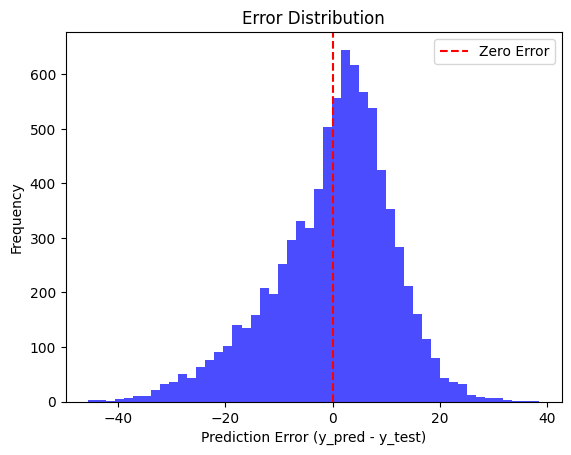

Mean Error: -0.01711641707059768
Median Error: 1.637413998665659
Fraction of Predictions Below Actual: 43.21%


In [110]:
errors = y_pred - y_test

plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

mean_error = np.mean(errors)
median_error = np.median(errors)
below_zero = np.mean(errors < 0)  # Fraction of under-predictions
print(f"Mean Error: {mean_error}")
print(f"Median Error: {median_error}")
print(f"Fraction of Predictions Below Actual: {below_zero:.2%}")


---
## **3. Safety Factors and Analysis** 
Experiment with safety factors to improve TP rate. 

MSLE: 0.21359053523826418
Initial TPR (no safety factor): 0.5679208404593208


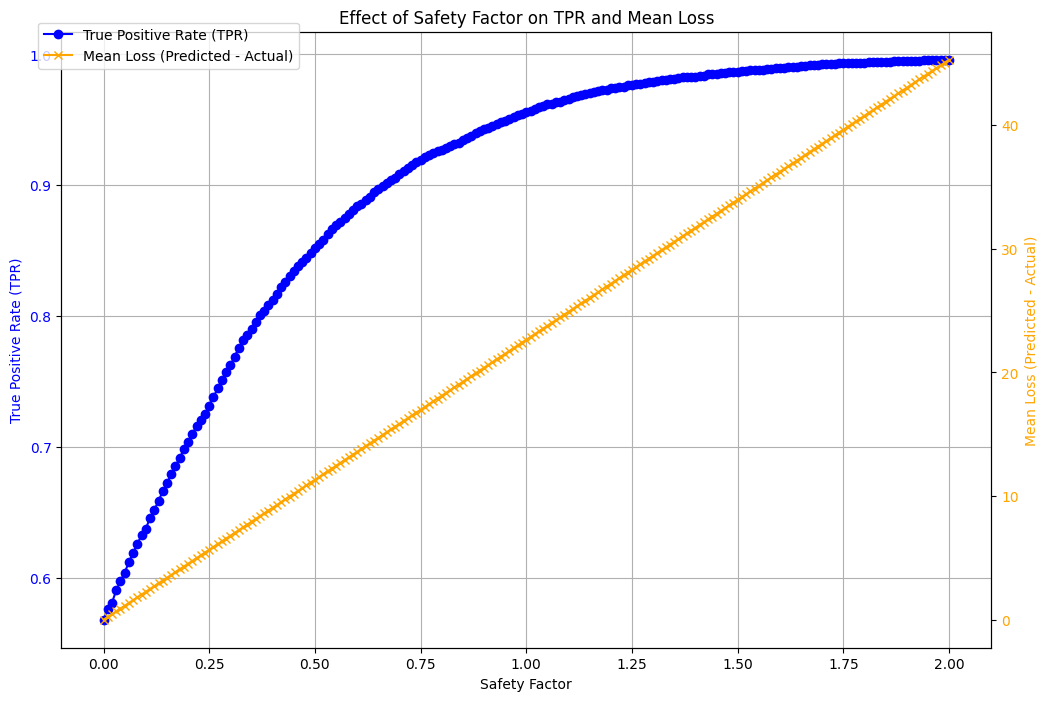

In [111]:
# Initialize lists to store results
safety_factors = np.arange(0.00, 2.01, 0.01)
tpr_values = []
loss_values = []

# Original predictions
y_pred = model.predict(X_test)

# Compute MSLE (unchanged)
msle_value = mean_squared_log_error(y_test, y_pred)

# Loop through safety factors
for sf in safety_factors:
    # Apply safety factor to predictions
    adjusted_pred = y_pred * (1 + sf)

    # Compute TP Rate
    pred_binary = (adjusted_pred >= y_test).astype(int)
    tp_rate = pred_binary.mean()

    # Compute Mean Loss (average difference between predicted and actual)
    mean_loss = np.mean(adjusted_pred - y_test)

    # Store TPR and Loss
    tpr_values.append(tp_rate)
    loss_values.append(mean_loss)

# Print MSLE and initial TPR (without safety factor)
print("MSLE:", msle_value)
print("Initial TPR (no safety factor):", tpr_values[0])

# Plot TPR and Mean Loss with Dual Y-Axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot TPR on the left y-axis
ax1.plot(safety_factors, tpr_values, marker='o', color='blue', label='True Positive Rate (TPR)')
ax1.set_xlabel('Safety Factor')
ax1.set_ylabel('True Positive Rate (TPR)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Effect of Safety Factor on TPR and Mean Loss')
ax1.grid(True)

# Plot Mean Loss on the right y-axis
ax2 = ax1.twinx()
ax2.plot(safety_factors, loss_values, marker='x', color='orange', label='Mean Loss (Predicted - Actual)')
ax2.set_ylabel('Mean Loss (Predicted - Actual)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend for clarity
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


---
## **4. Feature Importance** 
Top features contributing to prediction

             Feature  Importance
1        Description   13.762049
6              Round   11.246972
4         Instructor   10.976767
10       BidderCount    9.845648
8        SubjectArea    7.420172
14      class1_venue    6.874173
9        CatalogueNo    4.990700
7             Window    4.653636
21          exam_day    4.627551
2            Section    4.599706
13  class1_starttime    4.027660
5                 AY    2.765665
12        class1_day    2.740266
22    exam_starttime    2.686104
0               Term    2.210135


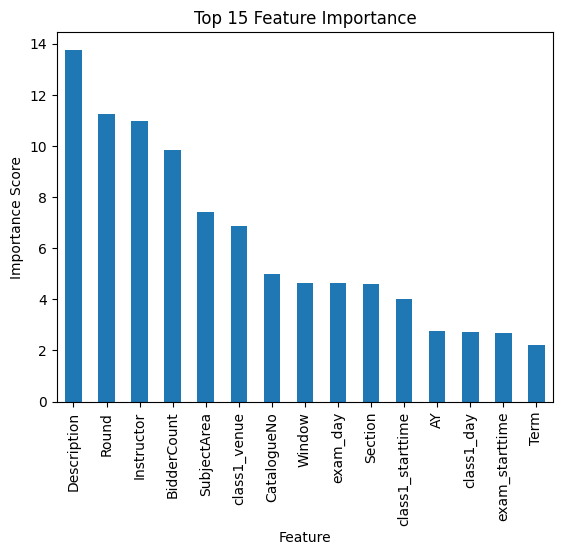

In [116]:
# Use model's internal feature names
features = model.feature_names_

# Get feature importance scores
feature_importance = model.get_feature_importance(type='FeatureImportance')

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 15 features
top_features = importance_df.head(15)
print(top_features)

# Visualize feature importance
top_features.plot(kind='bar', x='Feature', y='Importance', legend=False, title="Top 15 Feature Importance")
plt.ylabel("Importance Score")
plt.show()


---
## **5. Bootstrap-based Confidence Interval**
We'll retrain the model multiple times on bootstrap samples of the training data and predict each time.

### **5.1 Sample Prediction**

In [125]:
# Define the transformation function
def preprocess_new_data(data):
    # Convert numeric columns
    data['AY'] = pd.to_numeric(data['AY'], errors='coerce').astype('int64')
    data['Term'] = pd.to_numeric(data['Term'], errors='coerce').astype('int64')
    data['Vacancy'] = pd.to_numeric(data['Vacancy'], errors='coerce').astype('int64')
    data['BidderCount'] = pd.to_numeric(data['BidderCount'], errors='coerce').astype('int64')
    data['Round'] = pd.to_numeric(data['Round'], errors='coerce').fillna(0).astype('int32')
    data['Window'] = pd.to_numeric(data['Window'], errors='coerce').astype('int64')

    # Ensure categorical columns are properly typed
    categorical_cols = [
        'Description', 'Section', 'Instructor', 'SubjectArea', 'CatalogueNo',
        'Grading Basis', 'class1_day', 'class1_starttime', 'class1_venue',
        'class2_day', 'class2_starttime', 'class2_venue',
        'class3_day', 'class3_starttime', 'class3_venue',
        'exam_day', 'exam_starttime'
    ]
    for col in categorical_cols:
        data[col] = data[col].fillna("NA").astype('object')

    # Convert date columns to datetime
    if 'exam_startdate' in data.columns:
        data['exam_startdate'] = pd.to_datetime(data['exam_startdate'], errors='coerce')

        # Extract day and month from `exam_startdate`
        data['exam_date'] = data['exam_startdate'].dt.day.fillna(0).astype('int32')
        data['exam_month'] = data['exam_startdate'].dt.month.fillna(0).astype('int32')

        # Drop the original `exam_startdate` column
        data = data.drop(columns=['exam_startdate'], errors='ignore')
    else:
        # If `exam_startdate` is missing, add placeholder columns
        data['exam_date'] = 0
        data['exam_month'] = 0

    # Ensure `exam_date` and `exam_month` are integers
    data['exam_date'] = data['exam_date'].astype('int32')
    data['exam_month'] = data['exam_month'].astype('int32')

    return data



In [133]:
# Define the new data instance
new_data = pd.DataFrame({
    'Term': [2],
    'Description': ["Enterprise Solution Management"],
    'Section': ["G1"],
    'Vacancy': [43],
    'Instructor': ["RAFAEL J. BARROS"],
    'Grading Basis': ["Graded"],
    'class1_day': ["Mon"],
    'class1_starttime': ["08:15"],
    'class1_venue': ["SOE/SCIS2 Seminar Room B1-2"],
    'class2_day': ["NA"],
    'class2_starttime': ["NA"],
    'class2_venue': ["NA"],
    'class3_day': ["NA"],
    'class3_starttime': ["NA"],
    'class3_venue': ["NA"],
    'exam_startdate': ["21-Apr-2025"], 
    'exam_day': ["Mon"],
    'exam_starttime': ["13:00"],
    'AY': [2024],
    'Round': [1],
    'Window': [1],
    'SubjectArea': ["IS"],
    'CatalogueNo': ["214"],
    'BidderCount': [38]
})

In [134]:
# Apply preprocessing
new_data_preprocessed = preprocess_new_data(new_data)

# Ensure column order matches training data
expected_columns = [
    'Term', 'Description', 'Section', 'Vacancy', 'Instructor', 'AY', 'Round',
    'Window', 'SubjectArea', 'CatalogueNo', 'BidderCount', 'Grading Basis',
    'class1_day', 'class1_starttime', 'class1_venue', 'class2_day', 'class2_starttime',
    'class2_venue', 'class3_day', 'class3_starttime', 'class3_venue',
    'exam_day', 'exam_starttime', 'exam_date', 'exam_month'
]
new_data_preprocessed = new_data_preprocessed[expected_columns]

# Predict with the main model
single_pred = model.predict(new_data_preprocessed)
print("Predicted Min Bid:", single_pred[0])

Predicted Min Bid: 20.64847671811813



---
### **5.2 Confident Interval using boostrapping**
Estimate a 95% confidence interval using bootstrapping.

We will:
1. Take a single new data point.
2. Perform bootstrap by training multiple models on resampled data.
3. Predict on the single instance each time.
4. Compute mean and std of these predictions.
5. Derive a 95% CI (mean ± 1.96*std).

In [128]:
n_bootstrap = 10
bootstrap_preds = []

for i in range(n_bootstrap):
    # Sample training data with replacement
    sample = train_data.sample(frac=1.0, replace=True)
    X_sample = sample[features]
    y_sample = sample[target]
    
    temp_model = CatBoostRegressor(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        cat_features=cat_features,
        verbose=False
    )
    temp_model.fit(X_sample, y_sample)
    
    # Predict on the single new instance
    single_boot_pred = temp_model.predict(new_data_preprocessed)
    bootstrap_preds.append(single_boot_pred[0])

bootstrap_preds = np.array(bootstrap_preds)
mean_pred = bootstrap_preds.mean()
std_pred = bootstrap_preds.std()

# Approximate 95% CI assuming normal distribution
ci_lower = mean_pred - 1.96 * std_pred
ci_upper = mean_pred + 1.96 * std_pred

print(f"Single Instance Prediction: {mean_pred:.2f}")
print(f"Approx. 95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

Single Instance Prediction: 23.80
Approx. 95% Confidence Interval: [21.98, 25.62]



---
## **6. Conclusion**

### **What Can Be Concluded**
1. **Model improvements**:
   - The inclusion of class timings and grading basis marginally improved accuracy.
   - Handling outliers in preprocessing enhanced the model’s ability to generalize.
2. **Insights into Features**:
   - As expected, the **instructor**, **course description**, and **bidding round** were the most influential predictors.
   - Class timings (e.g., morning vs. evening slots) had a noticeable impact on bid prices.
3. **Performance of Additional Enhancements**:
   - Safety factors were effective in improving TPR but increased over-predictions.
   - Confidence intervals provided actionable insights for bid recommendations.

### **What to Do Next**
1. **Data Collection**:
   - Collaborate with students to crowdsource individual bid data for richer insights.
2. **Deployment to website**
   - Allowing students to use the model while generating additional insights, adhering to privacy policies.

Thank you for experimenting with me! Hope to develop better models that are more capable of predicting min bid prices!